In [1]:
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from typing import TypedDict, Dict, List, Any
from langchain_ollama import OllamaLLM
import toml
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_ollama.chat_models import ChatOllama
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

In [2]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    location: str

In [3]:
import random

model = ChatOllama(base_url="http://localhost:11434", model="mistral", max_tokens=2048, temperature=0.7)

@tool
def get_setting():
    """Get the current setting of the game."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    # location: str = "Baldur's Gate"
    # system_prompt = SystemMessage(
    #     content=f"You are a talented dungeon master running a D&D campaign. Describe the scene to the player based on the location. Location: {location}"
    # )
    # response = model.invoke([system_prompt, HumanMessage(content="Describe the scene")]).content
    # print(response)
    # return response
    return "Baldur's Gate"

@tool
def roll_dice(num_dice: int, num_sides: int) -> Dict[str, str]:
    """
    Roll a number of dice with a given number of sides.
    Ensure that the number of dice and sides are valid integers
    and respect the rules of D&D.
    Args:
        num_dice (int): The number of dice to roll.
        num_sides (int): The number of sides on each die.
    Returns:
        str: The result of the roll.
    """
    results = [random.randint(1, num_sides) for _ in range(num_dice)]
    return {f"{num_dice}d{num_sides}": f"{sum(results)}"}

# make a list of the tools
tools = [get_setting, roll_dice]
# bind the tools to the model
model = model.bind_tools(tools)


In [4]:
# create a mapping of tool names to tool objects
tools_by_name = {tool.name: tool for tool in tools}

# Nodes
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        print(f"Tool call: {tool_call}")
        tool_result = tools_by_name[tool_call['name']].invoke(tool_call['args'])
        print(f"Tool call output: {tool_call}")
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        """You are a talented dungeon master running a D&D campaign. 
        You have a set of tools to help you with your campaign.
        You can call these tools to get information about the world, roll dice, etc.
        After a tool call, tell the next part of the story based on the context and tool call results."""
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

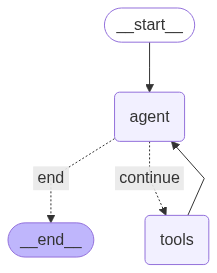

In [5]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
import torchaudio as ta
from chatterbox.tts import ChatterboxTTS
import torch

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the TTS model
tts_model = ChatterboxTTS.from_pretrained(device="cuda")

c:\Users\Benjamin Combs 2018\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Benjamin Combs 2018\AppData\Local\Programs\Python\Python313\Lib\site-packages\diffusers\models\lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


loaded PerthNet (Implicit) at step 250,000


In [12]:
AUDIO_PROMPT_PATH = "./resources/gandalf_dialog.wav"

# Main interaction loop
def main_loop():
    state = AgentState(messages=[], location="Baldur's Gate")
    print("Welcome to the D&D adventure! Type 'exit' to quit.")
    
    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            print("Exiting the adventure. Goodbye!")
            break
        
        # Add the user's message to the state
        state["messages"].append(HumanMessage(content=user_input))
        
        # Run the workflow
        outputs = graph.invoke(state)
        
        # Get the AI's response
        ai_response = outputs["messages"][-1].content
        wav = tts_model.generate(ai_response, audio_prompt_path=AUDIO_PROMPT_PATH)
        ta.save("./response.wav", wav, tts_model.sr)
        
        print(f"DM: {ai_response}")

# Start the main loop
main_loop()


Welcome to the D&D adventure! Type 'exit' to quit.


c:\Users\Benjamin Combs 2018\AppData\Local\Programs\Python\Python313\Lib\contextlib.py:109: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
Sampling:  95%|█████████▍| 946/1000 [00:26<00:01, 35.31it/s]


DM:  As you open your eyes, you find yourself standing in the middle of a bustling city square, surrounded by towering buildings and the hum of daily life. The sun is setting, casting long shadows across the cobblestone streets. You have no memories of how you got here or who you are, but you can feel a sense of adventure stirring within you. To your left stands an imposing guildhall with the emblem of the Order of the Gauntlet etched into its stone facade. A tavern to the right, The Jolly Oliphaunt, seems like a good place to start asking questions and gather information about this mysterious city.
Exiting the adventure. Goodbye!
